In [13]:
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd, textblob, string
pd.set_option('display.max_colwidth' , None) #To show the whole tweet field
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics,svm
import seaborn as pl
import re
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup

Training Set: (31962, 3) 31962
Test Set: (17197, 2) 17197
Positive:  92.98542018647143 %
Negative:  7.014579813528565 %


C:\Users\lalit.gaur\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

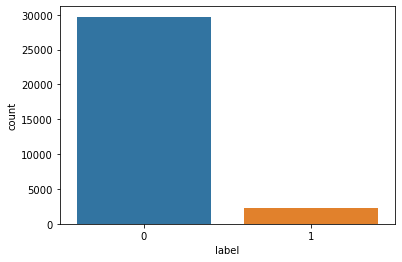

In [14]:
#Import Training and Testing Data
train = pd.read_csv(r"D:\Task\Analytics_Vidhya\Twitter_Sentiment_Analysis\train_E6oV3lV.csv")
print("Training Set:"% train.columns, train.shape, len(train))
test = pd.read_csv(r"D:\Task\Analytics_Vidhya\Twitter_Sentiment_Analysis\test_tweets_anuFYb8.csv")
print("Test Set:"% test.columns, test.shape, len(test))
#Percentage of Positive/Negative
print("Positive: ", train.label.value_counts()[0]/len(train)*100,"%")
print("Negative: ", train.label.value_counts()[1]/len(train)*100,"%")
#Show a bar chart to explore the difference in classes
pl.countplot(train["label"])

In [15]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [16]:
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9/]+'
combined_pat = r'|'.join((pat1, pat2))
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)    
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(letters_only)    
    sentence=[]
    for word in words:
        sentence.append(word)
        sentence.append(" ")
    words="".join(sentence).strip()    
    return words
nums = [0,len(train)]
clean_tweet_texts = []
for i in range(nums[0],nums[1]):
    clean_tweet_texts.append(tweet_cleaner(train['tweet'][i]))
nums = [0,len(test)]
test_tweet_texts = []
for i in range(nums[0],nums[1]):
    test_tweet_texts.append(tweet_cleaner(test['tweet'][i]))
train_clean = pd.DataFrame(clean_tweet_texts,columns=['tweet'])
train_clean['label'] = train.label
train_clean['id'] = train.id
test_clean = pd.DataFrame(test_tweet_texts,columns=['tweet'])
test_clean['id'] = test.id

In [19]:
train[train['label']==1].head()

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia


In [20]:
train_clean[train_clean['label']==1].head()

,tweet,label,id
13,cnn calls michigan middle school build the wall chant tcot,1,14
14,no comment in australia opkillingbay seashepherd helpcovedolphins thecove helpcovedolphins,1,15
17,retweet if you agree,1,18
23,lumpy says i am a prove it lumpy,1,24
34,it s unbelievable that in the st century we d need something like this again neverump xenophobia,1,35


In [21]:
#constructing the normalized mapping (Outer Dictionary)
tempMapping = {}
'''tuple of words) -> {dict: word -> *normalized* number of times the word appears following the tuple}
Example: {('cnn', 'calls'): {'michigan': 1.0}
Contains the set of words that can start sentences'''
mapping = {}
starts = []
'''We want to be able to compare words independent of their capitalization. This is not strong case here as all data set consists of tweets which are normalized to small letter.'''
def fixCaps(word):
    # Ex: "FOO" -> "foo"
    if word.isupper() and word != "I":
        word = word.lower()
        # Ex: "LaTeX" => "Latex"
    elif word [0].isupper():
        word = word.lower().capitalize()
        # Ex: "wOOt" -> "woot"
    else:
        word = word.lower()
    return word
#Create Dictionary keys
def toHashKey(lst):
    return tuple(lst)
'''Returns the tweets, split into a list of words by adding . to the end of each tweet, there are no punctuation.'''
def wordlist(data):
    split_it = '. '.join([text for text in data])
    wordlist = [fixCaps(w) for w in re.findall(r"[\w']+|[.,!?;]", split_it)]    
    return wordlist
'''addItemToTempMapping -- adds "word" to the "tempMapping" dict under "history".
tempMapping (and mapping) both match each word to a list of possible next words.
Given history = ["the", "rain", "in"] and word = "Spain", we add "Spain" to
the entries for ["the", "rain", "in"], ["rain", "in"], and ["in"].'''
def addItemToTempMapping(history, word):
    global tempMapping
    while len(history) > 0:
        first = toHashKey(history)
        if first in tempMapping:
            if word in tempMapping[first]:
                tempMapping[first][word] += 1.0
            else:
                tempMapping[first][word] = 1.0
        else:
            tempMapping[first] = {}
            tempMapping[first][word] = 1.0
        history = history[1:]
# Building and normalizing the mapping
def buildMapping(wordlist, markovLength):
    global tempMapping
    starts.append(wordlist [0])
    for i in range(1, len(wordlist) - 1):
        if i <= markovLength:
            history = wordlist[: i + 1]
        else:
            history = wordlist[i - markovLength + 1 : i + 1]
        follow = wordlist[i + 1]
        '''if the last elt was a period, add the next word to the start list'''
        if history[-1] == "." and follow not in ".,!?;":
            starts.append(follow)
        addItemToTempMapping(history, follow)
    # Normalize the values in tempMapping, put them into mapping
    for first, followset in tempMapping.items():
        total = sum(followset.values())
        # Normalizing here:
        mapping[first] = dict([(k, v / total) for k, v in followset.items()])
# Returns the next word in the sentence (chosen randomly),
# given the previous ones.
def next(prevList):
    sum = 0.0
    retval = ""
    index = random.random()
    # Shorten prevList until it's in mapping
    while toHashKey(prevList) not in mapping:
        try:
            prevList.pop(0)
        except:
            prevList=random.choice(starts)
    # Get a random word from the mapping, given prevList
    for k, v in mapping[toHashKey(prevList)].items():
        sum += v
        if sum >= index and retval == "":
            retval = k
    return retval
def genSentence(markovLength):
    # Start with a random "starting word"
    curr = random.choice(starts)
    sent = curr.capitalize()
    prevList = [curr]
    # Keep adding words until we hit a period
    while (curr not in "."):
        curr = next(prevList)
        prevList.append(curr)        
        # if the prevList has gotten too long, trim it
        if len(prevList) > markovLength:
            prevList.pop(0)
        if (curr not in ".,!?;"):
            sent += " " # Add spaces between words (but not punctuation)
        sent += curr
    return sent

In [22]:
#extracting racist/sexist tweets
negativeTweets=train_clean[train_clean['label']==1]
newlyGeneratedTweets=pd.DataFrame()
#Repeat with the New Sentences for 3 times
for i in range(3):
    data = negativeTweets['tweet']
    markovLength = 2
    numberofsentences=data.size
    buildMapping(wordlist(data), markovLength)
    newTweets = []
    for i in range(numberofsentences):
        newTweet=genSentence(markovLength)
        # Sentence should have more than 10 chatachters
        if len(newTweet) > 15:
            newTweets.append(newTweet)
    d={'tweet':newTweets,'label':1}
    df=pd.DataFrame(data=d)
    newlyGeneratedTweets=newlyGeneratedTweets.append(df)
    newlyGeneratedTweets=newlyGeneratedTweets.reset_index()
    newlyGeneratedTweets=newlyGeneratedTweets.drop(['index'], axis=1)
    print(newlyGeneratedTweets.shape)

(2011, 2)
(4090, 2)
(6150, 2)


Positive:  77.9806884970613 %
Negative:  22.019311502938706 %


C:\Users\lalit.gaur\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

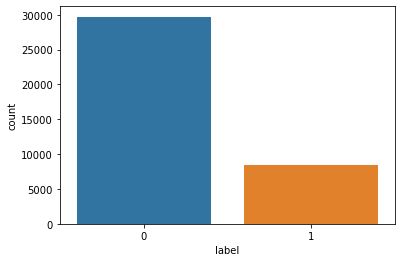

In [23]:
train_cl=train_clean.append(newlyGeneratedTweets)
#train_cl=train_cl.append(hateTweets)
train_cl=train_cl.drop(['id'], axis=1)
#Percentage of Positive/Negative
print("Positive: ", train_cl.label.value_counts()[0]/len(train_cl)*100,"%")
print("Negative: ", train_cl.label.value_counts()[1]/len(train_cl)*100,"%")
pl.countplot(train_cl["label"])

In [24]:
# Remove small tweets
train_cl=train_cl[train_cl['tweet'].str.len()>15]
x_train, x_test, y_train, y_test = train_test_split(train_cl['tweet'],train_cl['label'], test_size=0.33, random_state=42)
pr=Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                     ('tfidf', TfidfTransformer(use_idf=True, norm='l2')),
                     ('clf', MultinomialNB(alpha=0.02))])
pr.fit(x_train, y_train)
predictions = pr.predict(x_test)
f1Score=metrics.f1_score(y_test,predictions)
print(f1Score)

0.9705464868701207


In [25]:
#Now working with Real challenge Data
train_x=train_cl['tweet']
valid_x=test_clean['tweet']
train_y=train_cl['label']
pr=Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                     ('tfidf', TfidfTransformer(use_idf=True, norm='l2')),
                     ('clf', MultinomialNB(alpha=0.02))])
pr.fit(x_train, y_train)
predictions = pr.predict(valid_x)
d={'id':test['id'],'label':predictions}
df=pd.DataFrame(data=d)
df.to_csv("test_predictions_MultiNomialNB_Markov.csv", index=False)